In [252]:
import os
import json
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

RESULTS_FOLDER = 'models'

In [253]:
def conf2tuple(conf: dict):
    conf = conf['training_config']
    return (conf['learning_rate'], conf['batch_size'],
            conf['e_decay'],conf['target_fraction'])

In [49]:
def folder_results(folder_path: str):
    with open(os.path.join(folder_path, 'config.json')) as conf_file:
        conf = json.load(conf_file)

    rewards = np.genfromtxt(os.path.join(folder_path, 'rewards.csv'), delimiter=',')

    return conf, rewards, conf['validation_result']['solver']


def get(folder_name = RESULTS_FOLDER, only_solved=True):
    solved_cnt = 0
    conf2rewards_history = defaultdict(list)
    
    if type(folder_name) == str: 
        for folder in os.listdir(folder_name):
            # for file in os.listdir(os.path.join(RESULTS_FOLDER, folder)):
            conf, rewards, solved = folder_results(os.path.join(folder_name, folder))

            if solved or not only_solved:
                solved_cnt += 1
                conf2rewards_history[conf2tuple(conf)].append(rewards)
                # smoothed_rewards = savgol_filter(rewards, 100, 1)

        # print(solved_cnt)
        return conf2rewards_history
    
    for fname in folder_name:
        for folder in os.listdir(fname):
                # for file in os.listdir(os.path.join(RESULTS_FOLDER, folder)):
                conf, rewards, solved = folder_results(os.path.join(fname, folder))

                if solved or not only_solved:
                    solved_cnt += 1
                    conf2rewards_history[conf2tuple(conf)].append(rewards)
                    # smoothed_rewards = savgol_filter(rewards, 100, 1)

                    # print(conf['training_config'])
                    # if solved:
            # plt.show()
            # print(solved_cnt)
    
    return conf2rewards_history

## HPO

In [200]:
a = get([f'run {i}' for i in range(1,4)])
len(a)

49

In [51]:
a_all = get([f'run {i}' for i in range(1,4)], only_solved=False)
len(a_all)

59

In [44]:
b = []

for k in a.keys():
    b.append(len(a[k]))

print(Counter(b), sorted(b, reverse=True))

Counter({1: 27, 2: 14, 3: 8}) [3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [53]:
b_all = []

for k in a_all.keys():
    b_all.append(len(a_all[k]))

print(Counter(b_all)) #, sorted(b_all, reverse=True))

Counter({4: 26, 5: 23, 3: 7, 2: 2, 8: 1})


In [ ]:
(conf['learning_rate'], conf['batch_size'],
            conf['e_decay'],conf['target_fraction'])

In [56]:
best_keys = []

for k in a.keys():
    if len(a[k]) == 3:
        print(k)
        best_keys.append(k)

(0.05, 1750, 0.9996, 55.0)
(0.05, 1500, 0.9994499662246678, 77.5)
(0.05, 1000, 0.999, 10.0)
(0.00047287080450158787, 1750, 0.9996, 10.0)
(0.00047287080450158787, 2000, 0.9996, 10.0)
(0.00047287080450158787, 2000, 0.999, 55.0)
(0.0001, 1500, 0.9996, 77.5)
(0.0001, 2000, 0.9994499662246678, 77.5)


In [54]:
for k in a_all.keys():
    if len(a_all[k]) == 8:
        print(k)

(0.00047287080450158787, 1500, 0.9994499662246678, 55.0)


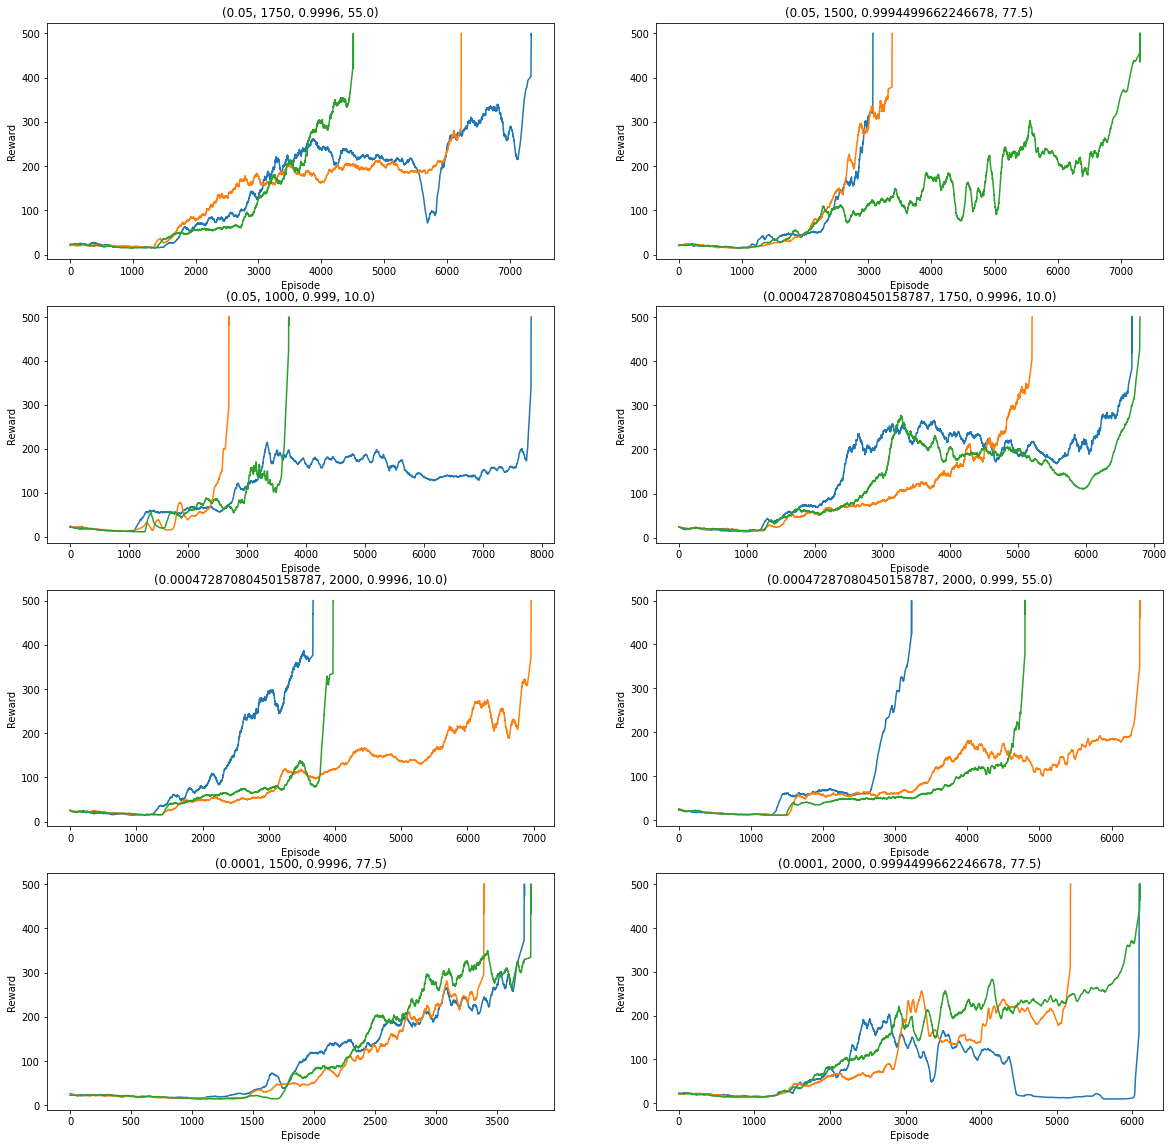

In [105]:
plt.figure(figsize=(20,20))

for index, key in enumerate(best_keys):
    plt.subplot(4,2,index+1)
    plt.title(str(key))
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    for i in a[key]:
        plt.plot(np.concatenate([savgol_filter(i, 100, 1), i[-5:]]))

plt.show()

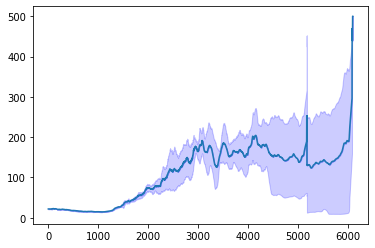

In [192]:
plt.plot(range(len(means)), means)
plt.fill_between(range(len(means)),means, means+stds, color='blue', alpha=0.2)
plt.fill_between(range(len(means)),means, means-stds,  color='blue', alpha=0.2)

In [269]:
def plot_conf(runs, title='', figsize=(7,7), save_file_name=None):
    smoothed = [np.concatenate([savgol_filter(run, 100, 1), run[-5:]]) for run in runs]
    
    max_len = max([len(i) for i in smoothed])
    means = []
    stds = []

    for i in range(max_len):
        means.append(np.mean([run[i] for run in smoothed if len(run) > i]))
        stds.append(np.std([run[i] for run in smoothed if len(run) > i]))
    

    means = np.array(means)
    stds = np.array(stds)
    
    plt.figure(figsize=figsize)
    plt.plot(range(len(means)), means)
    plt.fill_between(range(len(means)),means, means+stds, color='blue', alpha=0.2)
    plt.fill_between(range(len(means)),means, means-stds,  color='blue', alpha=0.2)
    plt.xlabel('Episode', fontsize=18)
    plt.ylabel('Reward', fontsize=18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title, fontsize=20)
    
    if save_file_name is not None:
        plt.savefig(save_file_name)

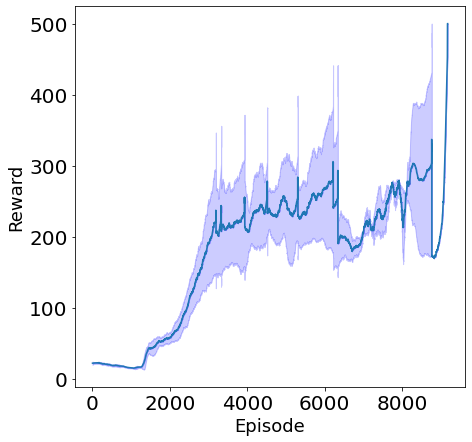

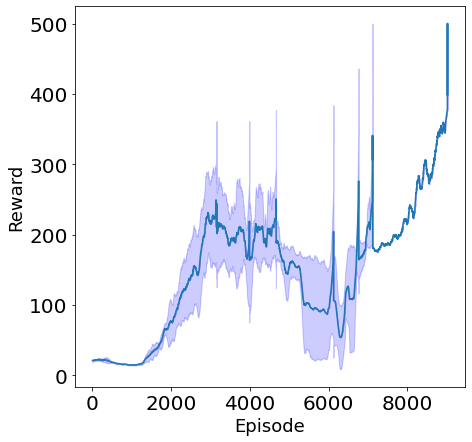

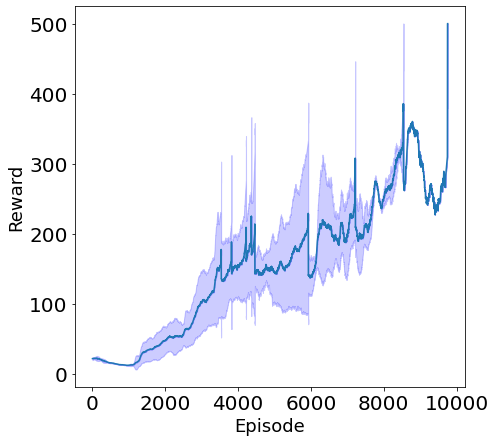

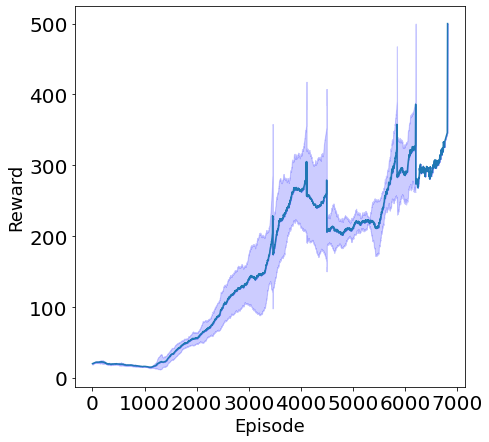

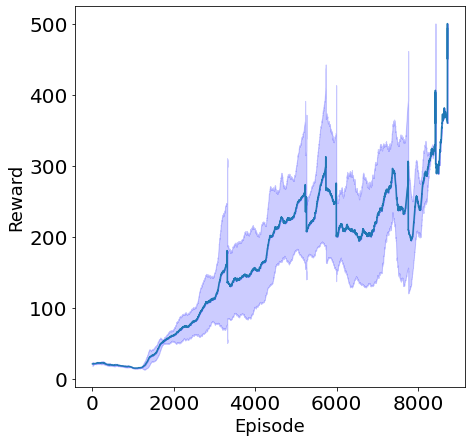

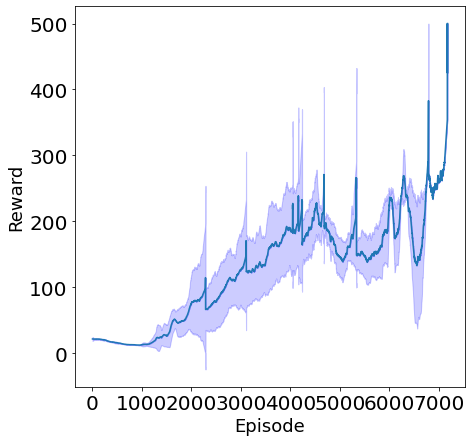

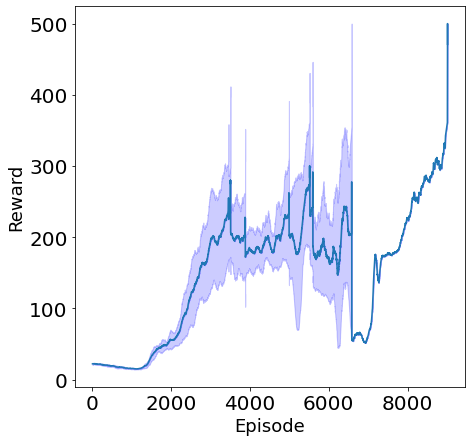

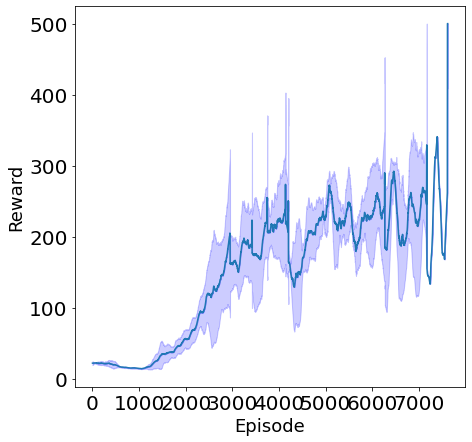

In [241]:
for i in range(1,9):
    plt.figure(figsize=(7,7))
    plot_conf(list(get(f'Final Run {i}', only_solved=False).values())[0])
    plt.savefig(f'Final Run {i}.png')

In [238]:
def get_statsss(runs):
    smoothed = [np.concatenate([savgol_filter(run, 100, 1), run[-5:]]) for run in runs]
    
    max_len = max([len(i) for i in smoothed])
    means = []
    stds = []

    for i in range(max_len):
        means.append(np.mean([run[i] for run in smoothed if len(run) > i]))
        stds.append(np.std([run[i] for run in smoothed if len(run) > i]))
    

    means = np.array(means)
    stds = np.array(stds)
    print(means.mean(), stds.mean())

In [240]:
for i in range(1,9):
    get_statsss(list(get(f'Final Run {i}', only_solved=False).values())[0])

177.87705050726058 35.34921679721828
147.4457436381687 28.687176589380876
153.49933466547827 31.066929383046578
158.01020263454183 23.294033915449294
162.13138544192174 43.199007947528564
126.29803121541958 33.09574061205517
151.04434484812444 29.40901770752831
150.48138985282657 34.600480144211126


In [243]:
def get_mean_validation(folder_name = RESULTS_FOLDER, only_solved=False):
    validations = []
    
    if type(folder_name) == str: 
        for folder in os.listdir(folder_name):
            conf, rewards, solved = folder_results(os.path.join(folder_name, folder))

            if solved or not only_solved:
                validations.append(conf['validation_result']['mean_value'])
                
    
    return validations

In [251]:
for i in range(1,9):
    print(round(np.mean(get_mean_validation(f'Final Run {i}')),2))

437.46
426.48
392.66
444.55
448.65
438.84
449.16
427.51


### Calculate rerun solvations

In [287]:
for i in range(1,9):
    print(len(list(get(f'Final Run {i}', only_solved=True).values())[0]))

2
3
1
2
3
4
3
2


## Ablation study

[array([18., 12., 45., ...,  8.,  9., 10.]),
 array([22., 24., 24., ..., 10.,  9.,  8.]),
 array([37., 17., 29., ...,  9.,  9.,  9.]),
 array([17., 39., 15., ..., 14., 14., 16.]),
 array([34., 11., 13., ...,  9., 10.,  8.]),
 array([21., 33., 10., ...,  9.,  9., 10.]),
 array([29., 35., 20., ..., 11., 11.,  9.]),
 array([26., 15., 14., ...,  8., 10., 10.]),
 array([17., 14., 16., ..., 20., 28., 25.]),
 array([39., 19., 22., ..., 10.,  9., 10.])]

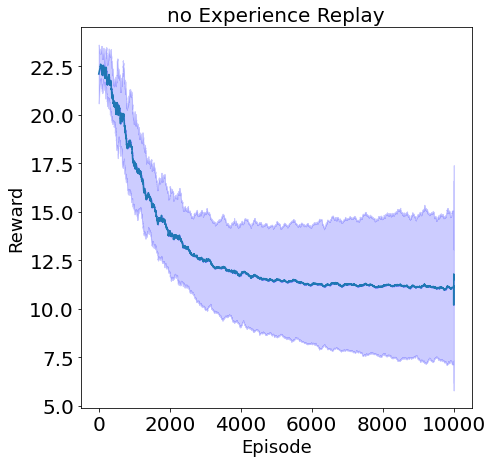

In [276]:
noER = get('noER', only_solved=False)
noER_vals = list(noER.values())[0]
plot_conf(noER_vals, 'no Experience Replay', (7,7), 'no Experience Replay.png')
noER_vals

[array([ 36.,  10.,  22., ..., 107., 114., 100.]),
 array([ 12.,  13.,  24., ..., 417., 375., 165.]),
 array([ 14.,  60.,  17., ..., 126., 134., 133.]),
 array([ 21.,  11.,  18., ..., 232., 166., 242.]),
 array([ 22.,  24.,  17., ..., 456., 447., 500.]),
 array([ 27.,  12.,  58., ..., 283., 483., 500.]),
 array([ 58.,  23.,  11., ..., 356., 330., 500.]),
 array([ 23.,  16.,  18., ..., 198., 241., 234.]),
 array([ 38.,  14.,  24., ..., 500., 500., 500.]),
 array([ 13.,  13.,  29., ..., 500., 262., 500.])]

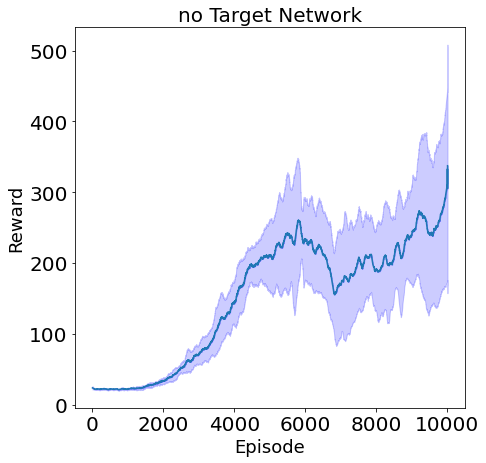

In [277]:
noTN = get('noTN', only_solved=False)
noTN_vals = list(noTN.values())[0]
plot_conf(noTN_vals, 'no Target Network', (7,7), 'no Target Network.png')
noTN_vals

[array([13., 15., 68., ...,  9.,  8.,  9.]),
 array([12., 16., 19., ..., 10., 12.,  8.]),
 array([14.,  9., 14., ..., 10.,  9.,  9.]),
 array([13., 21., 18., ..., 11.,  9., 10.]),
 array([16., 16., 23., ..., 11., 11.,  9.]),
 array([48., 34., 13., ..., 10., 10.,  9.]),
 array([12., 13., 25., ...,  9., 11.,  9.]),
 array([19., 13., 18., ...,  9.,  8., 10.]),
 array([18., 15., 14., ...,  8.,  8.,  9.]),
 array([12., 23., 15., ..., 11., 10.,  9.])]

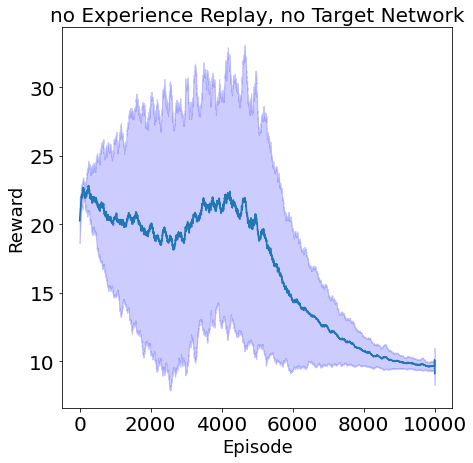

In [279]:
noERnoTN = get('noERnoTN', only_solved=False)
noERnoTN_vals = list(noERnoTN.values())[0]
plot_conf(noERnoTN_vals, 'no Experience Replay, no Target Network', (7,7), 'no Experience Replay, no Target Network.png')
noERnoTN_vals